# Classification of Oil Palm Plantation

In this notebook, we train a deep learning model to perform a binary classification task for detecting oil palm plantation in Planet Images. The label  `0` means there is no oil palm plantation in the image, and `1` indicates the presence of an oil palm plantation. Each image has a 3 meter spatial resolution, has 3 channels (RGB) and a size of 256 $\times$ 256 pixels. This dataset has been collected from [Kaggle](https://www.kaggle.com/c/widsdatathon2019/data), and was proposed in the Women in Data Science Datathon 2019.


**Outline**
- Baseline Model: Random Forest, 
- Data Preprocessing, 
- Data Augmentation (employing strategies for dealing with imbalance classes),
- Model development and finetuning, 
- Model evaluation
- Summary

### Workspace utilities
- In this section of the notebook, we have all the essential libraries that was used in this notebook and other utility functions that were used in the visualization of data, model outcomes and other essential parameters. 

In [1]:
# import essential libraries
import os
import pandas as pd
import numpy as np
import rasterio
from matplotlib import pyplot as plt
# SET PROJECT PATH
PROJECT_PATH = "../assignment"
TRAIN_PATH = "../assignment/train"

In [2]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")

In [194]:
# PyTorch related Libraries
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision.io import read_image
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
import pytorch_lightning
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

from PIL import Image

### **Baseline Random Forest classifier**
- Here, we train a baseline Random Forest classifier for identifying the `Oil Palm` and `No Oil Palm` classes. This is taken as the starting accuracy that our deep learning model would perform even better than. 

#### Read the data.


In [4]:
train_df = pd.read_csv(os.path.join(PROJECT_PATH, "traindata.csv"))
print(os.path.join(PROJECT_PATH, "train") )
train_df.sample(10)

../assignment\train


,img_id,has_oilpalm
6397,train/img_6397.jpg,1
3260,train/img_3260.jpg,0
6504,train/img_6504.jpg,0
2453,train/img_2453.jpg,0
5792,train/img_5792.jpg,1
2219,train/img_2219.jpg,0
6738,train/img_6738.jpg,0
2214,train/img_2214.jpg,0
1030,train/img_1030.jpg,0
4527,train/img_4527.jpg,0


In [5]:
print("The length of the dataset is: ", len(train_df))

The length of the dataset is:  7677


The ``img_id`` column indicates the relative path to the image and the ``has_oilpalm`` columns give the corresponding class index. Let us now dowload the data and train a simple Random Forest algorithm on the flatten representation of the training images.
As the data are **big** (~12GB if we download them in a float64 numpy array), we will use here only a subset of the data.

In [6]:
N = 500

#-- Getting the training dataset (X,y)
X = np.zeros((N,256*256*3), dtype=np.uint16)

y = np.zeros((N,), dtype=np.uint8)

train_rf_model = train_df.sample(n=N)

for n in range(N):
  X[n,:] = rasterio.open(os.path.join(PROJECT_PATH,train_rf_model.iloc[n]['img_id'])).read().flatten()
  y[n] = train_rf_model.iloc[n]['has_oilpalm']

C:\Users\rufai\anaconda3\lib\site-packages\rasterio\__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [7]:
#-- Training a RF model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_features=100, max_depth=25, oob_score=True, n_jobs=-1)
rf.fit(X,y)
print('OOB error: ', rf.oob_score_)

OOB error:  0.884


### **Data preparation and pre-processing**

In this section of the notebook, series of Exploratory Data Analysis were carried out to better understand the data distribution, nature of the labels and these datasets were preprocessed to produce an optimal data to be fed into the Deep Learning Classifier.

#### Data Exploration

In [8]:
train_df.head()

,img_id,has_oilpalm
0,train/img_0000.jpg,0
1,train/img_0001.jpg,0
2,train/img_0002.jpg,0
3,train/img_0003.jpg,0
4,train/img_0004.jpg,0


In [9]:
train_df.tail()

,img_id,has_oilpalm
7672,train/img_7672.jpg,0
7673,train/img_7673.jpg,0
7674,train/img_7674.jpg,0
7675,train/img_7675.jpg,0
7676,train/img_7676.jpg,0


In [10]:
# Basic Class Statistics
train_df[(train_df['has_oilpalm'] == 0)].describe()

,has_oilpalm
count,6722.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [11]:
# Class Distribution
train_df["has_oilpalm"].value_counts()

0    6722
1     955
Name: has_oilpalm, dtype: int64

In [12]:
has, hasnot = train_df["has_oilpalm"].value_counts()
print(has)
print(hasnot)

6722
955


In [13]:
print("The proportion of `HasNo Oil Palm Plantation` to `Has Oil Palm Plantation` is: ", np.around((hasnot/has), 3)*100, "%")

The proportion of `HasNo Oil Palm Plantation` to `Has Oil Palm Plantation` is:  14.2 %


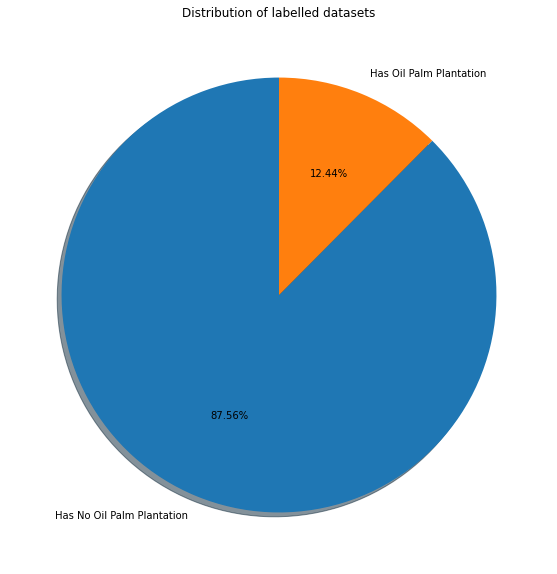

In [14]:
label = 'Has No Oil Palm Plantation', 'Has Oil Palm Plantation'

plt.figure(figsize = (10,10))
plt.pie(train_df.groupby('has_oilpalm').size(), labels = label, autopct='%1.2f%%', shadow=True, startangle=90)
plt.title("Distribution of labelled datasets")
plt.show()

At a first glance at the data, we can already see a challenge -- a very high proportion of classes with labels `0` and a significantly small portion with labels `1` (about 14% of the total datasets). This shows a bias in our dataset towards a particular class (in this case class `0`).

In [15]:
for i, idx in enumerate(train_df[train_df['has_oilpalm'] == 1]['img_id'][-5:]):
    print(idx)

train/img_7564.jpg
train/img_7570.jpg
train/img_7580.jpg
train/img_7665.jpg
train/img_7668.jpg


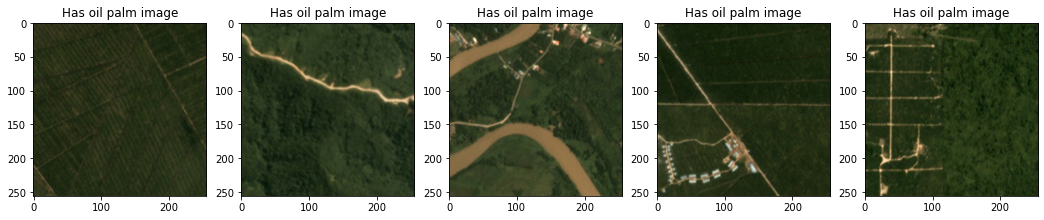

In [16]:
import matplotlib.image as img
fig,ax = plt.subplots(1,5,figsize = (18,12))

for i, idx in enumerate(train_df[train_df['has_oilpalm'] == 1]['img_id'][-5:]):
    path = os.path.join(idx)
    ax[i].imshow(img.imread(path))
    ax[i].set_title(f"Has oil palm image")

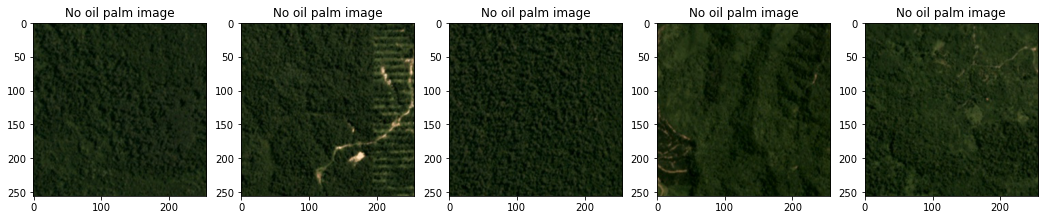

In [17]:
import matplotlib.image as img
fig,ax = plt.subplots(1,5,figsize = (18,12))

for i, idx in enumerate(train_df[train_df['has_oilpalm'] == 0]['img_id'][:5]):
    path = os.path.join(idx)
    ax[i].imshow(img.imread(path))
    ax[i].set_title(f"No oil palm image")

#### Data preprocessing
In this section of the notebook, functions and paramaters were defiend to load the data, normalized and split into train, test and validation sets to be passed to the model. Normalizing the data was important to ensure that the model training is stable, fast and minimize the influence of outliers in the model development. 

In [18]:
# function to display data set
def imshow(image, ax=None, title=None):
    """Function shows the image in a given databatch. Simply an Imshow for Tensor"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 16))
    else:
        fig, ax = plt.subplots(figsize=ax)
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))

    fig.suptitle("Random Samples of Train Datasets", fontsize=20)

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    if type(title) == torch.Tensor:
        for i in title:
            if i==0:
                ax.set_title("{}".format("Has No Oil Palm"))
            else:
                ax.set_title("{}".format("Has Oil Palm"))
    ax.grid(False)
    plt.axis('off')
    ax.imshow(image)
    
    return ax

##### Data Loader

In [19]:
#%%file utils/dataloader.py
from torch.utils.data import Dataset
from PIL import Image

class OilPalmDataset(Dataset):
    """ DataSet class to read in images, transform their pixel values, and 
    stores the image tensors and labels
    """

    def __init__(
        self,
        dataframe,
        img_dir,
        transform=None):

        """
        Instantiate the OilPalmDataset class.
        
        Args:
            dataframe (pd.DataFrame): a dataframe with a row for each image and 
            column for img_id with a path to the TIF files.
            img_dir (pd.DataFrame): a dataframe with a path to the train dataset
            transform (list, optional): a list of transforms to apply to the feature data such as flipping
        Dataset ([inherit from the Dataset module]): [PyTorch Dataset object]
        """

        self.data = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.labels = self.data['has_oilpalm']

        # # Images
        self.images =self.data['img_id']
        #classes
        self.classes = set(self.labels)
        # Number of classes
        self.num_classes = len(self.classes)
        

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        img_path = self.images.iloc[idx]

        # Open image from the image path provided
        img = Image.open(img_path)
        
        # Apply transformation on the image tensors
        if self.transform:
            img = self.transform(img)
        # Load the labels associated with the images
        label = self.labels.iloc[idx]
        
        return img, label

In [21]:
# Data Normalization
from utils.dataloader import OilPalmDataset
BATCH_SIZE = 64

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((256,256)),
                                #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
                                ])

datasets = OilPalmDataset(train_df, TRAIN_PATH, transform=transform)

# split data into train/val/test
TRAIN_SIZE = int(0.7 * len(datasets))
TEST_SIZE = len(datasets) - TRAIN_SIZE
train_dataset, test_dataset = random_split(datasets, [TRAIN_SIZE, TEST_SIZE])
TRAIN_SIZE = int(0.7 * len(train_dataset) )
VAL_SIZE = len(train_dataset) - TRAIN_SIZE
train_dataset, val_dataset = random_split(train_dataset, [TRAIN_SIZE, VAL_SIZE])

# DATALOADER
train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
val_dataset_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

# display size of training sets
print("Total number of images available: ", len(datasets))
print("Training set size: ", len(train_dataset))
print("Test set size: ", len(test_dataset))
print("Validation set size: ", len(val_dataset))

Total number of images available:  7677
Training set size:  3761
Test set size:  2304
Validation set size:  1612


In [22]:
# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

<AxesSubplot:>

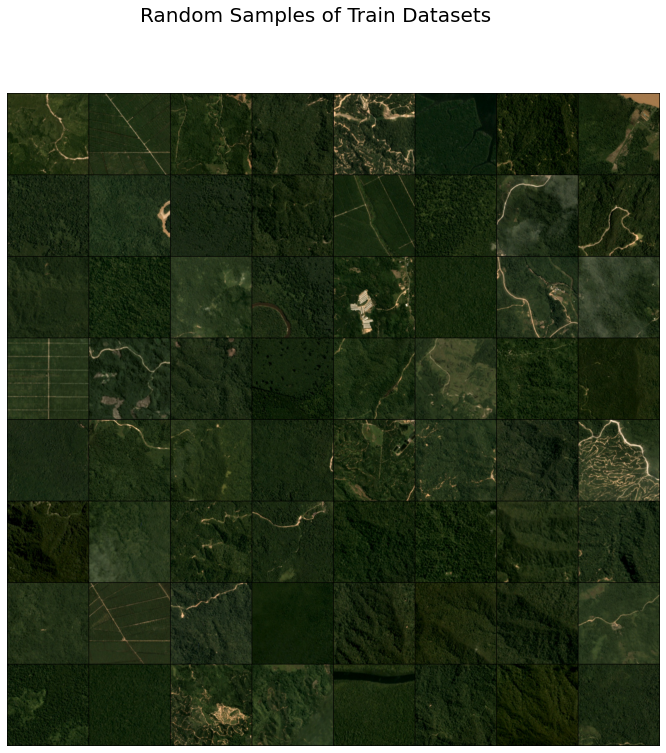

In [23]:
# display Data
from torchvision.utils import make_grid
# display batch of 8 images from test_sample
dataiter = iter(train_dataset_loader)

sample_batch = dataiter.next()

imshow(make_grid(sample_batch[0]),ax =(20, 12), title="Random Display of images")

### Data Augmentation

The WiDS datasets is largely unbalanced, having more class labels with no palm plantations (0) than those with palm plantations. To bulwark for the possible challenges that this imbalanced sets could cause in the model training, we employ a commonly used technique in computer vision to improve model performance known as Data Augmentation. <a href="https://vinesmsuic.github.io/2020/08/11/cnn-dataaug/#reference">Data Augmentation </a> is a technique that is used to increase the diversity of data available for trainig models, without collecting new data. The most used data augmentation techniques include cropping, padding, horizontal and vertical flipping and other affine transformations. PyTorch Transforms implements most of these functions, and are usually employed with the Albumentations framework. At a first a look, this might look sufficient for tackling the imbalance, but it is not immediately sufficient. To develop a more robust data balancing technique, the data augmentation techniques available has to be used along with one or a combination of the following strategies: 
- Undersampling, 
- Oversampling, 
- Class weighting, 
- Focal loss

The strategy employed usually depend on the peculiarities of the dataset available for training our data. In this use case, the oversampling techique was employed, but without creating an entirely new datasets. This was achieved through the specialized module for data balancing in the PyTorch API. Oversampling is simply increasing the number of samples in the minor samples so as to reach a near equal or equal number of samples in the datasets. This approach is more suited for deep learning approaches since having more datasets could possibily increase the feature learning rather than using less data. However, this could also lead to other challenges like model overfitting due to the large repetition of a small sets of input features. Notwithstanding, this approach was selected to improve the feature representation and reduce bias in the input feature datasets.



In [133]:
from torch.utils.data import WeightedRandomSampler
import torch.nn as nn 

In [135]:
IMG_DIR = os.path.join(PROJECT_PATH, "train")
IMG_DIR

'../assignment\\train'

In [181]:
#PYTORCH LIGHTNING DATA MODULE
class LitOilPalmData(pl.LightningDataModule):
    def __init__(self, IMG_DIR, dataframe, BATCH_SIZE):
        """Lightning Data Module for loading the train, validation and test dataloader into the 
        Main Model. Class returns all the 

        Args:
            IMG_DIR ([Path]): Path to the image directory
            dataframe ([pd.DataFrame]): Pandas dataframe that contains the `has_oilpalm` column
            BATCH_SIZE ([int]): 
        """
        super().__init__()

        self.IMG_DIR = IMG_DIR
        self.batch_size = BATCH_SIZE
        self.dataframe = dataframe

        # AUGMENTATION POLICY
        self.augmentation = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256,256)),
            transforms.RandomHorizontalFlip(p=0.25),
            transforms.RandomVerticalFlip(p=0.25),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# normalize data
        ])        
        self.num_classes = 2

    def prepare_data(self):
        self.datasets = OilPalmDataset(self.dataframe, IMG_DIR, transform=self.augmentation)

    def setup(self, stage=None):
        train_size = 0.7
        TRAIN_SIZE = int(train_size * len(datasets))
        TEST_SIZE = len(datasets) - TRAIN_SIZE
        train_dataset, test_dataset = random_split(datasets, [TRAIN_SIZE, TEST_SIZE])
        TRAIN_SIZE = int(train_size * len(train_dataset) )
        VAL_SIZE = len(train_dataset) - TRAIN_SIZE

        if stage in (None, "fit"):
            self.train_dataset, self.val_dataset = random_split(
                train_dataset,
                [TRAIN_SIZE, VAL_SIZE]
            )
            
        if stage in (None, "test"):
            self.test_dataset = test_dataset

    def train_dataloader(self):
        # Train data sampler
        sample_weights_train = [0]*len(self.train_dataset)
        labels = [l for _, l in self.train_dataset.dataset]
        num_labels = [labels.count(i) for i in  np.unique(labels)]
        class_weights_train = [(len(self.train_dataset.dataset) - weight) for weight in num_labels]
        for idx, (data, label) in enumerate(self.train_dataset):
            class_weight = class_weights_train[label]
            sample_weights_train[idx] = class_weight
        
        train_sampler = WeightedRandomSampler(sample_weights_train, num_samples=len(sample_weights_train), replacement=True)
        return DataLoader(self.train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)

    def val_dataloader(self):
        # Validation data sampler
        sample_weights_val = [0]*len(self.val_dataset)
        
        labels = [l for _, l in self.val_dataset.dataset]
        num_labels = [labels.count(i) for i in  np.unique(labels)]
        class_weights_val = [(len(self.val_dataset.dataset) - weight) for weight in num_labels]
        
        for idx, (data, label) in enumerate(self.val_dataset):
            class_weight = class_weights_val[label]
            sample_weights_val[idx] = class_weight
            
        val_sampler = WeightedRandomSampler(sample_weights_val, num_samples=len(sample_weights_val), replacement=True)
        return DataLoader(self.val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

    def test_dataloader(self):
        sample_weights_test = [0]*len(self.test_dataset)
        labels = [l for _, l in self.test_dataset.dataset]
        num_labels = [labels.count(i) for i in  np.unique(labels)]
        class_weights_test = [(len(self.test_dataset.dataset) - weight) for weight in num_labels]
        
        for idx, (data, label) in enumerate(self.test_dataset):
            class_weight = class_weights_test[label]
            sample_weights_test[idx] = class_weight
            
        test_sampler = WeightedRandomSampler(sample_weights_test, num_samples=len(sample_weights_test), replacement=True)
        return DataLoader(self.test_dataset, batch_size=BATCH_SIZE, sampler=test_sampler)


In [182]:
# CONFIRM DATA BALANCE
data = LitOilPalmData(IMG_DIR, train_df, BATCH_SIZE)
data.prepare_data()
data.setup()
train_dataset_loader = data.train_dataloader()

In [183]:
num_hasoilpalm = 0
num_nooilpalm = 0
for data, label in train_dataset_loader:
    num_hasoilpalm += torch.sum(label ==1)
    num_nooilpalm += torch.sum(label == 0)

print(num_hasoilpalm)
print(num_nooilpalm)

tensor(1907)
tensor(1854)


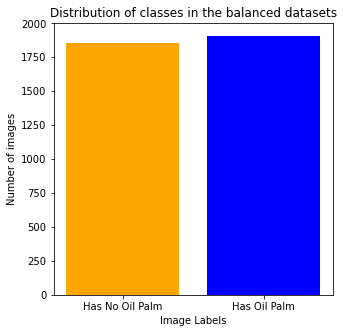

In [201]:
value = [num_nooilpalm, num_hasoilpalm]
labels = ["Has No Oil Palm", "Has Oil Palm"]
c = "orange", "blue"
fig = plt.figure(figsize=(5, 5))
plt.bar(labels, value, color=c)
plt.xlabel("Image Labels")
plt.ylabel("Number of images")
plt.title("Distribution of classes in the balanced datasets", fontsize = 12)
plt.show()

As shown above the number of features with the `label 0` and `label 1` are relatively in the same value range distribution as seen the figure. With this adjustment, we can start developing our model confident that we have at least reduced the inherent bias in the data. Nevertheless, this approach is not sufficient enough to capture other issues like noisy labels that might be associated with datasets.

## Model Development and fine-tuning
Here, we start experimenting methods to develop our model. We will start with a Baseline Deep Learning Image Classifier developed on the back of the LeNet-5 Architecture, proposed by Professor Yann LeCun and other researchers in his 1998 papers titled <a href ="http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf">`Gradient-Based Learning Applied to Document Recognition`</a>. The LeNet-5 is a Multi-layer Convolutional Neural Network used for Image Classification. 
Here, a variation of the LeNet-5 architecture was proposed with some additional Batch Normalization, Max Pooling Layers, and 


In [26]:
import torch
from torch.nn import functional as F
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.loggers import WandbLogger
import torchmetrics

#### Baseline model
- LeNet7

In [174]:
# DEFINE MODEL ARCHITECTURE
class LitLeNet7(pl.LightningModule):
    def __init__(self, n_channels, n_classes):
        """
        Model class built on the LeNet7 architecture tested for optimal performance on image classification tasks

        Args:
            n_channels ([int]): the number of bands in the given input image
            n_classes ([type]): the expected number of output.
        """
        super(LitLeNet7, self).__init__()
        #-- convolutional layers
        self.conv1 = nn.Conv2d(n_channels, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)
        self.conv5 = nn.Conv2d(128, 128, 5)
       
        #-- fully connected layers
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, n_classes)

        # compute metrics
        self.train_accuracy = torchmetrics.Accuracy()
        self.train_f1 = torchmetrics.F1(num_classes=n_classes, average="macro")
        
        self.val_accuracy = torchmetrics.Accuracy()
        self.val_f1 = torchmetrics.F1(num_classes=n_classes, average='macro')
        self.val_fbeta = torchmetrics.FBeta(num_classes=n_classes, average="micro")

        self.test_accuracy = torchmetrics.Accuracy()
        self.test_f1 = torchmetrics.F1(num_classes=n_classes, average="macro")
        self.test_fbeta = torchmetrics.FBeta(num_classes=n_classes, average="micro")
        

    def forward(self, x):
        """
        MODEL FORWARD PROPAGATION: the steps to be implemented during model inference. 
        """
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = F.max_pool2d(F.relu(self.conv5(x)), 2)
        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        logits = self.fc2(x)
        return logits

    
    def training_step(self, batch, batch_idx):
        """
        Logic for a single training step
        """

        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log("Train_loss", loss, prog_bar=True, on_epoch=True, logger=True)

        #extract metrics
        self.train_accuracy.update(logits, y)
        self.log('Acc_train', self.train_accuracy(logits,y))
        train_F1  = self.train_f1(logits, y)
        self.log("Train_F1", train_F1)
        val_Fbeta = self.test_fbeta(logits, y)
        self.log("Val_FBeta", val_Fbeta)

        return loss
        
    def test_step(self, batch, batch_idx):
        """
        Logic for a single testing step
        """
        # load images and labels
        x, y = batch
        # forward pass
        logits = self(x)
        
        #metrics
        self.test_accuracy.update(logits, y)
        self.test_f1.update(logits, y)
        self.test_fbeta.update(logits, y)

        self.log('Acc_test', self.test_accuracy(logits,y))
        test_F1  = self.test_f1(logits, y)
        self.log("Test_F1", test_F1)
        test_Fbeta = self.test_fbeta(logits, y)
        self.log("Test_FBeta", test_Fbeta)
        

    def validation_step(self, batch, batch_idx):
        """
        Logic for a single validation step
        """
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log("Val_loss", loss, prog_bar=True, on_epoch=True, logger=True)

        #extract metrics
        self.val_accuracy.update(logits, y)
        self.val_f1.update(logits, y)
        self.val_fbeta.update(logits, y)

        return loss

    def train_epoch_end(self, train_epoch_end):
        #LOG EVALUATION METRICS
        self.log("Acc_train", value=self.train_accuracy.compute(), on_epoch=True, prog_bar=True, logger=True)
        self.log("Train_F1", self.train_f1.compute())

        #RESET AT EACH EPOCH
        self.train_accuracy.reset()
        print(f"\nTraining Accuracy: {self.train_accuracy.compute():.4f}, "\
            f"F1 Score: {self.train_f1.compute():.4f}")

    def validation_epoch_end(self, validation_epoch_end):
        #COMPUTE AND LOG EVALUATION METRICS
        self.log("Acc_val", value=self.val_accuracy.compute(), on_epoch=True, prog_bar=True, logger=True)
        self.log("Val_F1", self.val_f1.compute())
        self.log("Val_Fbeta", self.val_fbeta.compute())

        #RESET
        self.val_accuracy.reset()
        self.val_f1.reset()
        self.val_fbeta.reset()

    def test_epoch_end(self, test_epoch_end):
        self.log(
            "Acc_test", value = self.test_accuracy.compute(), on_epoch=True, prog_bar=True, logger=True
        )
        self.log("Test_F1", self.test_f1.compute())
        self.log("Test_FBeta", self.test_f1.compute())

        #RESET
        self.test_accuracy.reset()
        self.test_f1.reset()
        self.test_fbeta.reset()

        print(f"\Test Accuracy: {self.test_accuracy.compute():.4f}, "\
            f"F1 Score: {self.test_f1.compute():.4f}"\
            f"FBeta Score: {self.test_fbeta.compute():.4f}")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)


In [188]:
# LOAD DATA
data = LitOilPalmData(IMG_DIR, train_df, BATCH_SIZE)
data.setup()

#LOAD DATA FOR DISPLAY
val_samples = next(iter(data.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]
val_imgs.shape, val_labels.shape

(torch.Size([64, 3, 256, 256]), torch.Size([64]))

In [189]:
## FIT MODEL
import wandb
from pytorch_lightning.loggers import WandbLogger
os.environ["WANDB_API_KEY"] = "9862819c12461d6d8580b1a87fc3af6e6837b5dd"

model = LitLeNet7(3,2)
wandb_logger = WandbLogger(name= "LitLeNet7", project="Oil Palm Classification")

# DEFINE CALLBACKS
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="Val_loss", 
    dirpath="./best-model/len7/", 
    verbose=True, 
    mode="min"
    )

early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(
    monitor="Val_loss", 
    patience=5, 
    verbose=False, 
    mode="max"
    )

# DEFINE CUSTOM CALLBACKS
class ImagePredictionLogger(pl.Callback):
    """
    Custom image prediction logger. Displays image and logs the output on Wandb.
    """
    def __init__(self, val_samples, num_samples=16):
        super().__init__()
        self.num_samples = num_samples
        self.val_imgs, self.val_labels = val_samples
        
    def on_validation_epoch_end(self, trainer, pl_module):
        val_imgs = self.val_imgs.to(device=pl_module.device)
        val_labels = self.val_labels.to(device=pl_module.device)
       
        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, -1)
        
        trainer.logger.experiment.log({
            "Predictions":[wandb.Image(x, caption=f"Prediction:{pred}, Label:{y}") 
                           for x, pred, y in zip(val_imgs[:self.num_samples], 
                                                 preds[:self.num_samples], 
                                                 val_labels[:self.num_samples])]
            })



trainer = pl.Trainer( #define the training loop parameters
    gpus=1,
    max_epochs=40,
    precision=16, 
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stopping_callback, ImagePredictionLogger(val_samples, 32)]
    )

trainer.fit(model, data)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\rufai\anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name           | Type     | Params
---------------------------------------------
0  | conv1          | Conv2d   | 2.4 K 
1  | conv2          | Conv2d   | 51.3 K
2  | conv3          | Conv2d   | 102 K 
3  | conv4          | Conv2d   | 204 K 
4  | conv5          | Conv2d   | 409 K 
5  | fc1            | Linear   | 262 K 
6  | fc2            | Linear   | 258   
7  | train_accuracy | Accuracy | 0     
8  | train_f1       | F1       | 0     
9  | val_accuracy   | Accuracy | 0     
10 | val_f1         | F1       

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\rufai\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:655: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\rufai\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Validation sanity check: 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

C:\Users\rufai\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 85/85 [00:24<00:00,  3.45it/s, loss=0.628, v_num=lze2, Train_loss_step=0.615, Val_loss=0.576, Acc_val=0.723, Train_loss_epoch=0.658]

Epoch 0, global step 58: Val_loss reached 0.57579 (best 0.57579), saving model to "C:\Users\rufai\Downloads\assignment-instructions\assignment\best-model\len7\epoch=0-step=58.ckpt" as top 1


Epoch 1: 100%|██████████| 85/85 [00:24<00:00,  3.51it/s, loss=0.57, v_num=lze2, Train_loss_step=0.762, Val_loss=0.517, Acc_val=0.758, Train_loss_epoch=0.587] 

Epoch 1, global step 117: Val_loss reached 0.51669 (best 0.51669), saving model to "C:\Users\rufai\Downloads\assignment-instructions\assignment\best-model\len7\epoch=1-step=117.ckpt" as top 1


Epoch 2: 100%|██████████| 85/85 [00:24<00:00,  3.51it/s, loss=0.569, v_num=lze2, Train_loss_step=0.524, Val_loss=0.534, Acc_val=0.766, Train_loss_epoch=0.585]

Epoch 2, global step 176: Val_loss was not in top 1


Epoch 3: 100%|██████████| 85/85 [00:27<00:00,  3.13it/s, loss=0.502, v_num=lze2, Train_loss_step=0.452, Val_loss=0.442, Acc_val=0.810, Train_loss_epoch=0.513]

Epoch 3, global step 235: Val_loss reached 0.44234 (best 0.44234), saving model to "C:\Users\rufai\Downloads\assignment-instructions\assignment\best-model\len7\epoch=3-step=235.ckpt" as top 1


Epoch 4: 100%|██████████| 85/85 [00:25<00:00,  3.29it/s, loss=0.471, v_num=lze2, Train_loss_step=0.349, Val_loss=0.417, Acc_val=0.833, Train_loss_epoch=0.488]

Epoch 4, global step 294: Val_loss reached 0.41710 (best 0.41710), saving model to "C:\Users\rufai\Downloads\assignment-instructions\assignment\best-model\len7\epoch=4-step=294.ckpt" as top 1


Epoch 5: 100%|██████████| 85/85 [00:27<00:00,  3.12it/s, loss=0.464, v_num=lze2, Train_loss_step=0.514, Val_loss=0.419, Acc_val=0.828, Train_loss_epoch=0.504]

Epoch 5, global step 353: Val_loss was not in top 1


Epoch 5: 100%|██████████| 85/85 [00:27<00:00,  3.12it/s, loss=0.464, v_num=lze2, Train_loss_step=0.514, Val_loss=0.419, Acc_val=0.828, Train_loss_epoch=0.504]


In [195]:
trainer.test(model, data)
wandb.finish()

C:\Users\rufai\anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\rufai\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:655: UserWarning: Your `test_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
C:\Users\rufai\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing:  97%|█████████▋| 35/36 [00:07<00:00,  4.82it/s]\Test Accuracy: 0.0000, F1 Score: 0.0000FBeta Score: 0.0000
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Acc_test': 0.8103298544883728,
 'Test_F1': 0.8093520998954773,
 'Test_FBeta': 0.8093520998954773}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 36/36 [00:07<00:00,  4.68it/s]


C:\Users\rufai\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
C:\Users\rufai\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric F1 was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
C:\Users\rufai\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric FBeta was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Acc_test,▁
Acc_train,▁▅▅▅▆█▆
Acc_val,▁▃▄▇██
Test_F1,▁
Test_FBeta,▁
Train_F1,▁▅▅▅▇█▆
Train_loss_epoch,█▅▅▂▁▂
Train_loss_step,█▅▆▅▂▁▃
Val_F1,▁▃▃▆██
Val_FBeta,▁▅▅▅▆█▆
Val_Fbeta,▁▃▄▇██


Test Accuracy is 81%
Train Accuracy is 76.5%
Validation Accuracy is 82.7%

F1 Score on Test set is: 80.94%
F1 Score on Validation set is: 82.75%




### What does the Accuracy and Loss Charts looks like on the training and validation sets?


<iframe src="https://wandb.ai/ruphai/Oil%20Palm%20Classification/reports/Shared-panel-22-01-18-17-01-08--VmlldzoxNDU1MDQx?accessToken=afhzz12yf1wihze3jd17s2makfwpcht2o4hz0nxr9d9j5bkvmn1iynepmlyli6im" style="border:none;height:1024px;width:100%">

<iframe src="https://wandb.ai/ruphai/Oil%20Palm%20Classification/reports/Shared-panel-22-01-18-17-01-28--VmlldzoxNDU1MDQz?accessToken=9jk00g1bonmmg447rc3gmi7ypg600q7l7iufd77uhjt2qo12gvgyzqxpvqywvzh2" style="border:none;height:1024px;width:100%">

#### **Training and Accuracy Curve**
In the case above, we see that our validation accuracy is higher than the training accuracy. This could be due to any one of -- very small set of validation data, hence not properly representing the distribution of the data, or the model is very basic and is unable to cover the complexity of the data.
We can infer from this outcome that the training and accuracy curves shows that while the model learns well, it is not complex enough to capture all the intricacies of the data fed into in as shown in the drop in performance in the validation set. Nonewithstanding, the F1 score shows a high degree of balance between the model recall and precision reaching 82.75% on the validation dataset and 80.94% on the test datasets.

<iframe src="https://wandb.ai/ruphai/Oil%20Palm%20Classification/reports/Shared-panel-22-01-18-17-01-77--VmlldzoxNDU1MDY5?accessToken=4q55mpg4rghj3obebxhlbmk3kw00bfldmi14qd3g85inqh07x2fblaaagiazrosm" style="border:none;height:1024px;width:100%">

<iframe src="https://wandb.ai/ruphai/Oil%20Palm%20Classification/reports/Shared-panel-22-01-18-17-01-06--VmlldzoxNDU1MDYx?accessToken=8eqq45fmono6elozwyszq14yxztlgnobjbl4vl4djp6g3yj55i5d0nqirjd8aemq" style="border:none;height:1024px;width:100%">

#### **A Quick Look at the Distribution of the F1 Score per epoch**
Here, we see the evolution of the F1 Score metric as the model learns.This still shows the same patterns with validation accuracy is higher than training accuracy -- the validation F-Score returns higher score than the training score. This is a pointer the fact that our LeNet7 might not be well-trained to generalize to newly unseen data.

### What does the Prediction of LeNet7 look like?
A quick display of the predicted fields and their corresponidng labels. 

<iframe src="https://wandb.ai/ruphai/Oil%20Palm%20Classification/reports/Shared-panel-22-01-18-09-01-63--VmlldzoxNDUyOTcy?accessToken=1pp3xjd0whn69vdvapkxbjx5tq5to5oy1tweh8y7id1knix3thq1fvwyy0mxr7l1" style="border:none;height:1024px;width:100%" >

Hence, we test for a model with a much robust architecture. In the following section, we employed the used of Pretrained models.  

#### Working with pretrained models
- ResNet18

In [ ]:
import torchvision.models as models

In [196]:
class OilPalmRes(pl.LightningModule):
    def __init__(self, input_shape, num_classes, train_dataframe, learning_rate = 1e-3):
        """ Lightning model that freezes the firsty 17 layers of the ResNet18 model and 
        reconfigures the output layer

        Args:
            input_shape ([tuple]): a tuple containing the number of channel, height and width of the input image
            num_classes ([int]): number of output classes
            train_dataframe ([pd.DataFrame]): Pandas DataFrame containing the field `has_oilpalm`
            learning_rate ([Float or Double], optional): model hyperparameter for setting the rate of 
            change along the gradient computation curve. Defaults to 1e-3.
        """
        super().__init__()

        #log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.dim = input_shape
        self.num_classes = num_classes

        # instantiate pretrained resnet18 model
        self.feature_extractor = models.resnet18(pretrained=True)

        # freeze the layers
        self.feature_extractor.eval()
        for param in self.feature_extractor.parameters():
            param.requires_grad=False

        n_sizes =self._get_conv_output(input_shape)
        self.classifier = nn.Linear(n_sizes, num_classes)

        
        # compute metrics
        self.train_accuracy = torchmetrics.Accuracy()
        self.train_f1 = torchmetrics.F1(num_classes=num_classes, average="macro")
        
        self.val_accuracy = torchmetrics.Accuracy()
        self.val_f1 = torchmetrics.F1(num_classes=num_classes, average='macro')
        self.val_fbeta = torchmetrics.FBeta(num_classes=num_classes, average="micro")

        self.test_accuracy = torchmetrics.Accuracy()
        self.test_f1 = torchmetrics.F1(num_classes=num_classes, average="macro")
        self.test_fbeta = torchmetrics.FBeta(num_classes=num_classes, average="micro")

        # dataset
        self.datasets = OilPalmDataset(train_dataframe, TRAIN_PATH, transform=transform)

    def _get_conv_output(self, shape):
        """
        Function extracts the size of the output tensor going into the Linear layer 
        from the convolution block.
        """
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self._forward_features(tmp_input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
            
        return n_size

    def _forward_features(self, x):
        """
        Returns the feature tensor from the conv block.
        """
        x = self.feature_extractor(x)
        return x

    def forward(self, x):
        """
        steps to be implemented during model inference
        """
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.log_softmax(self.classifier(x), dim=1)

        return x

    def training_step(self, batch, batch_idx):
        """
        Logic for a single training step
        """

        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log("Train_loss", loss, prog_bar=True, on_epoch=True, logger=True)

        #extract metrics
        self.train_accuracy.update(logits, y)
        self.log('Acc_train', self.train_accuracy(logits,y))
        train_F1  = self.train_f1(logits, y)
        self.log("Train_F1", train_F1)
        val_Fbeta = self.test_fbeta(logits, y)
        self.log("Val_FBeta", val_Fbeta)

        return loss
        
    def test_step(self, batch, batch_idx):
        """
        Logic for a single testing step
        """
        # load images and labels
        x, y = batch
        # forward pass
        logits = self(x)
        
        #metrics
        self.test_accuracy.update(logits, y)
        self.test_f1.update(logits, y)
        self.test_fbeta.update(logits, y)

        self.log('Acc_test', self.test_accuracy(logits,y))
        test_F1  = self.test_f1(logits, y)
        self.log("Test_F1", test_F1)
        test_Fbeta = self.test_fbeta(logits, y)
        self.log("Test_FBeta", test_Fbeta)
        

    def validation_step(self, batch, batch_idx):
        """
        Logic for a single validation step
        """
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log("Val_loss", loss, prog_bar=True, on_epoch=True, logger=True)

        #extract metrics
        self.val_accuracy.update(logits, y)
        self.val_f1.update(logits, y)
        self.val_fbeta.update(logits, y)

        return loss

    def train_epoch_end(self, train_epoch_end):
        #LOG EVALUATION METRICS
        self.log("Acc_train", value=self.train_accuracy.compute(), on_epoch=True, prog_bar=True, logger=True)
        self.log("Train_F1", self.train_f1.compute())

        #RESET AT EACH EPOCH
        self.train_accuracy.reset()
        print(f"\nTraining Accuracy: {self.train_accuracy.compute():.4f}, "\
            f"F1 Score: {self.train_f1.compute():.4f}")

    def validation_epoch_end(self, validation_epoch_end):
        #COMPUTE AND LOG EVALUATION METRICS
        self.log("Acc_val", value=self.val_accuracy.compute(), on_epoch=True, prog_bar=True, logger=True)
        self.log("Val_F1", self.val_f1.compute())
        self.log("Val_Fbeta", self.val_fbeta.compute())

        #RESET
        self.val_accuracy.reset()
        self.val_f1.reset()
        self.val_fbeta.reset()

    def test_epoch_end(self, test_epoch_end):
        self.log(
            "Acc_test", value = self.test_accuracy.compute(), on_epoch=True, prog_bar=True, logger=True
        )
        self.log("Test_F1", self.test_f1.compute())
        self.log("Test_FBeta", self.test_f1.compute())

        #RESET
        self.test_accuracy.reset()
        self.test_f1.reset()
        self.test_fbeta.reset()

        print(f"\Test Accuracy: {self.test_accuracy.compute():.4f}, "\
            f"F1 Score: {self.test_f1.compute():.4f}"\
            f"FBeta Score: {self.test_fbeta.compute():.4f}")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [161]:
#DEFINE CALLBACKS
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="Val_loss",
    dirpath="./best-model/OilPalmRes/",
    filename = MODEL_CKPT,
    save_top_k = 5,
    verbose=True,
    mode="min")

early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(
    monitor="Val_loss",
    patience=5,
    verbose=False,
    mode="max")

#CUSTOM CALLBACKS
class ImagePredictionLogger(pl.Callback):
    """
    Custom image prediction logger. Displays image and logs the output on Wandb.
    """
    def __init__(self, val_samples, num_samples=16):
        super().__init__()
        self.num_samples = num_samples
        self.val_imgs, self.val_labels = val_samples
        
    def on_validation_epoch_end(self, trainer, pl_module):
        val_imgs = self.val_imgs.to(device=pl_module.device)
        val_labels = self.val_labels.to(device=pl_module.device)
       
        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, -1)
        
        trainer.logger.experiment.log({
            "Predictions":[wandb.Image(x, caption=f"Prediction:{pred}, Label:{y}") 
                           for x, pred, y in zip(val_imgs[:self.num_samples], 
                                                 preds[:self.num_samples], 
                                                 val_labels[:self.num_samples])]
            })

In [151]:
# Extract samples required by the custom ImagePredictionLogger callback to log image predictions.
# dm = model.setup()
val_samples = next(iter(model.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]
val_imgs.shape, val_labels.shape

(torch.Size([64, 3, 256, 256]), torch.Size([64]))

In [152]:
# FINETUNE
MODEL_CKPT_PATH = "./best-model/OilPalmRes/"
MODEL_CKPT = "-{epoch:02d}--{val_loss:.2f}"
Logger01 = WandbLogger(name= "OilPalmRes", project="Oil Palm Classification")
model = OilPalmRes(
    input_shape = (3, 256, 256),
    num_classes = 2,
    train_dataframe = train_df
)


trainer = pl.Trainer(
    gpus=1,
    max_epochs=40,
    precision=16, 
    logger = Logger01,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback,
        ImagePredictionLogger(val_samples, 32)
        ]
    )
trainer.fit(model)


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


wandb: WARNING Serializing object of type DataFrame that is 929061 bytes

  | Name              | Type     | Params
-----------------------------------------------
0 | feature_extractor | ResNet   | 11.7 M
1 | classifier        | Linear   | 2.0 K 
2 | train_accuracy    | Accuracy | 0     
3 | train_f1          | F1       | 0     
4 | val_accuracy      | Accuracy | 0     
5 | val_f1            | F1       | 0     
6 | val_fbeta         | FBeta    | 0     
7 | test_accuracy     | Accuracy | 0     
8 | test_f1           | F1       | 0     
9 | test_fbeta        | FBeta    | 0     
-----------------------------------------------
2.0 K     Trainable params
11.7 M    Non-trainable params
11.7 M    Total params
23.383    Total estimated model params size (MB)
C:\Users\rufai\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\rufai\Downloads\assignment-instructions\assignment\best-model\OilPalmRes exists and is not empty.
 

Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\rufai\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


C:\Users\rufai\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 85/85 [00:27<00:00,  3.10it/s, loss=0.314, v_num=60bz, Train_loss_step=0.212, Val_loss=0.306, Acc_val=0.894, Train_loss_epoch=0.455]

Epoch 0, global step 58: Val_loss reached 0.30614 (best 0.30614), saving model to "C:\Users\rufai\Downloads\assignment-instructions\assignment\best-model\OilPalmRes\-epoch=00--val_loss=0.00.ckpt" as top 5


Epoch 1: 100%|██████████| 85/85 [00:23<00:00,  3.67it/s, loss=0.249, v_num=60bz, Train_loss_step=0.197, Val_loss=0.266, Acc_val=0.909, Train_loss_epoch=0.255]

Epoch 1, global step 117: Val_loss reached 0.26598 (best 0.26598), saving model to "C:\Users\rufai\Downloads\assignment-instructions\assignment\best-model\OilPalmRes\-epoch=01--val_loss=0.00-v1.ckpt" as top 5


Epoch 2: 100%|██████████| 85/85 [00:23<00:00,  3.66it/s, loss=0.234, v_num=60bz, Train_loss_step=0.379, Val_loss=0.254, Acc_val=0.912, Train_loss_epoch=0.236]

Epoch 2, global step 176: Val_loss reached 0.25374 (best 0.25374), saving model to "C:\Users\rufai\Downloads\assignment-instructions\assignment\best-model\OilPalmRes\-epoch=02--val_loss=0.00-v1.ckpt" as top 5


Epoch 3: 100%|██████████| 85/85 [00:24<00:00,  3.50it/s, loss=0.249, v_num=60bz, Train_loss_step=0.158, Val_loss=0.247, Acc_val=0.912, Train_loss_epoch=0.231]

Epoch 3, global step 235: Val_loss reached 0.24728 (best 0.24728), saving model to "C:\Users\rufai\Downloads\assignment-instructions\assignment\best-model\OilPalmRes\-epoch=03--val_loss=0.00-v1.ckpt" as top 5


Epoch 4: 100%|██████████| 85/85 [00:25<00:00,  3.33it/s, loss=0.206, v_num=60bz, Train_loss_step=0.199, Val_loss=0.236, Acc_val=0.916, Train_loss_epoch=0.220] 

Epoch 4, global step 294: Val_loss reached 0.23642 (best 0.23642), saving model to "C:\Users\rufai\Downloads\assignment-instructions\assignment\best-model\OilPalmRes\-epoch=04--val_loss=0.00-v1.ckpt" as top 5


Epoch 5: 100%|██████████| 85/85 [00:24<00:00,  3.47it/s, loss=0.209, v_num=60bz, Train_loss_step=0.156, Val_loss=0.234, Acc_val=0.916, Train_loss_epoch=0.212] 

Epoch 5, global step 353: Val_loss reached 0.23375 (best 0.23375), saving model to "C:\Users\rufai\Downloads\assignment-instructions\assignment\best-model\OilPalmRes\-epoch=05--val_loss=0.00-v1.ckpt" as top 5


Epoch 5: 100%|██████████| 85/85 [00:24<00:00,  3.45it/s, loss=0.209, v_num=60bz, Train_loss_step=0.156, Val_loss=0.234, Acc_val=0.916, Train_loss_epoch=0.212]


In [153]:
trainer.test(model)
wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Serializing object of type DataFrame that is 929061 bytes
C:\Users\rufai\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 100%|██████████| 36/36 [00:09<00:00,  4.71it/s]\Test Accuracy: 0.0000, F1 Score: 0.0000FBeta Score: 0.0000
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Acc_test': 0.9240451455116272,
 'Test_F1': 0.8033545613288879,
 'Test_FBeta': 0.8033545613288879}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 36/36 [00:09<00:00,  3.80it/s]


C:\Users\rufai\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric Accuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
C:\Users\rufai\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric F1 was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
C:\Users\rufai\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric FBeta was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


Acc_test,▁
Acc_train,█▃▁▅▃▁▆
Acc_val,▁▆▇▇██
Test_F1,▁
Test_FBeta,▁
Train_F1,▆▅▁▁▂▁█
Train_loss_epoch,█▂▂▂▁▁
Train_loss_step,▅█▅▆▂▃▁
Val_F1,▁▆▆▆██
Val_FBeta,█▃▁▅▃▁▆
Val_Fbeta,▁▆▇▇██


The model outcomes of the ResNet18 shows us why using accuracy for evaluating the performance of classification models might be misleading. Here, we saw a significant jump in accuracy from the previous model reaching a test and validation accuracy of 93.75% and 91.6%. However, the F1 score suggests that the model is still imprecise with a score of 79.44% on the validation set and 80.34% on the test sets. The possible culprit causing this imprecision in the model outcome could be the noisy labels challenges, which has been highlighted previously. However, due to the time constraint of the model development, tackling the challenge of noisy labels was not implemented in this notebook.

### What does the Accuracy and Loss Charts looks like on the training and validation sets?

<iframe src="https://wandb.ai/ruphai/Oil%20Palm%20Classification/reports/Shared-panel-22-01-18-10-01-89--VmlldzoxNDUzMTk0?accessToken=xyjfar8ly1s6v2ad8tna35pxhcplv4empoch0d6ifd77we6lok2oodtevwbzstc1" style="border:none;height:1024px;width:100%">

<iframe src="https://wandb.ai/ruphai/Oil%20Palm%20Classification/reports/Shared-panel-22-01-18-10-01-68--VmlldzoxNDUzMjE4?accessToken=8xyjjsj9tqyx107k3dztt7yqetk8f4lfqgex5pq16sv9qv5a14flu32ka8c3ilkc" style="border:none;height:1024px;width:100%">

While the accuracy for the training sets appears to be unstable in this display, the loss suggests a relatively stable model, with enough complexity to capture the nuances of the data. The instability of the accuracy curve is attributable to the fact that the epoch size is low, resulting from the Early Stopping technique implemented in the model to stop the model after a number of steps when there is no changes in the validation loss. 

<iframe src="https://wandb.ai/ruphai/Oil%20Palm%20Classification/reports/Shared-panel-22-01-18-10-01-47--VmlldzoxNDUzMjIy?accessToken=y4zilf684cmwipvxyip8ded5f6b1hnia0u6z3o0powvtd7rcv3f69ywqgfov6c8b" style="border:none;height:1024px;width:100%">

The F1 Score distribution for the ResNet18 model shows a similar pattern to the LeNet7 model, with the validation F1 Score higher than the training score. On the first glance, this might be taught of as a good but on a second look, it raises questions on the model generalization. 

#### Prediction using the OilPalmRes Model. 
Here, we use our model in the inference mode using the test datasets, the best model was extracted from the folder containing the `.pth` files, with the model weights and parameters. And the predictions were also displayed. 

In [154]:
# storing the model checkpoints as Weight and Biases Artifacts
run = wandb.init(project='Oil Palm Classification', job_type='producer')

artifact = wandb.Artifact('model', type='model')
artifact.add_dir(MODEL_CKPT_PATH)

run.log_artifact(artifact)
run.join()

wandb: Adding directory to artifact (.\best-model\OilPalmRes)... Done. 0.3s


In [155]:
import re
# LOAD Best Model in CHECKPOINT directory
model_ckpts = os.listdir(MODEL_CKPT_PATH)
losses = []
for model_ckpt in model_ckpts:
    loss = re.findall("\d+\.\d+", model_ckpt)
    losses.append(float(loss[0]))

losses = np.array(losses)
best_model_index = np.argsort(losses)[0]
best_model = model_ckpts[best_model_index]
print(best_model)

-epoch=01--val_loss=0.00-v1.ckpt


In [156]:
inference_model = OilPalmRes.load_from_checkpoint(MODEL_CKPT_PATH+best_model)

In [241]:
MODEL_CKPT_PATH

'./best-model/OilPalmRes/'

In [ ]:
# PREDICT
def evaluate(model, loader):
    y_true = []
    y_pred = []
    for imgs, labels in loader:
        logits = inference_model(imgs)

        y_true.extend(labels)
        y_pred.extend(logits.detach().numpy())

    return np.array(y_true), np.array(y_pred)

y_true, y_pred = evaluate(inference_model, data.test_dataloader())

In [209]:
predicted_class = np.argmax(y_pred, axis = 1)

In [ ]:
inference_model1 = LitLeNet7.load_from_checkpoint('./best-model/len7/epoch=4-step=294.ckpt')
y_true1, y_pred1 = evaluate(inference_model1, data.test_dataloader())

#### Display Predictions

What does the output of OilPalm ResNet look like?

<iframe src="https://wandb.ai/ruphai/Oil%20Palm%20Classification/reports/Shared-panel-22-01-18-03-01-12--VmlldzoxNDUyMDI4?accessToken=9d9f4yq6k8ackbb6dh75wljnakl5ztjb26012u5o1j46na354lgb71o18hsj9bw1" style="border:none;height:1024px;width:100%">

## Model Evaluation
- Precision and Recall Curve

### Precision Recall Curve
We use the precision recall curve to compare the performance of the two models tested in this notebook. 

In [159]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

In [214]:
np.arange(0, 2)

array([0, 1])

In [216]:
# generate binary correctness labels across classes
binary_ground_truth = label_binarize(y_true,
                                     classes=np.arange(0, 2).tolist())

# compute a PR curve with sklearn like you normally would
precision_micro, recall_micro, _ = precision_recall_curve(binary_ground_truth.ravel(),
                                                          predicted_class.ravel())

In [225]:
run = wandb.init(project='Oil Palm Classification', job_type='evaluate')

data = [[x, y] for (x, y) in zip(recall_micro, precision_micro)]
sample_rate = int(len(data)/2)

table = wandb.Table(columns=["recall_micro", "precision_micro"], data=data[::sample_rate])
wandb.log({"precision_recall" : wandb.plot.line(table, 
                                                "recall_micro", 
                                                "precision_micro", 
                                                stroke=None, 
                                                title="Average Precision")})

run.join()

<iframe src="https://wandb.ai/ruphai/Oil%20Palm%20Classification/reports/Shared-panel-22-01-18-13-01-49--VmlldzoxNDUzODY0?accessToken=wmuj4x4rvytoe4ff0jm40em46u7y6j1lt8fb1g6fuqklc7zew00oxb0akq4yg7vp" style="border:none;height:1024px;width:100%">


### Confusion matrix

In [240]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
acc = accuracy_score(y_true, np.argmax(y_pred, axis=1))
print("The Global Accuracy of the OilPalmRes Model is: ", acc)

The Global Accuracy of the OilPalmRes Model is:  0.7230902777777778


<AxesSubplot:>

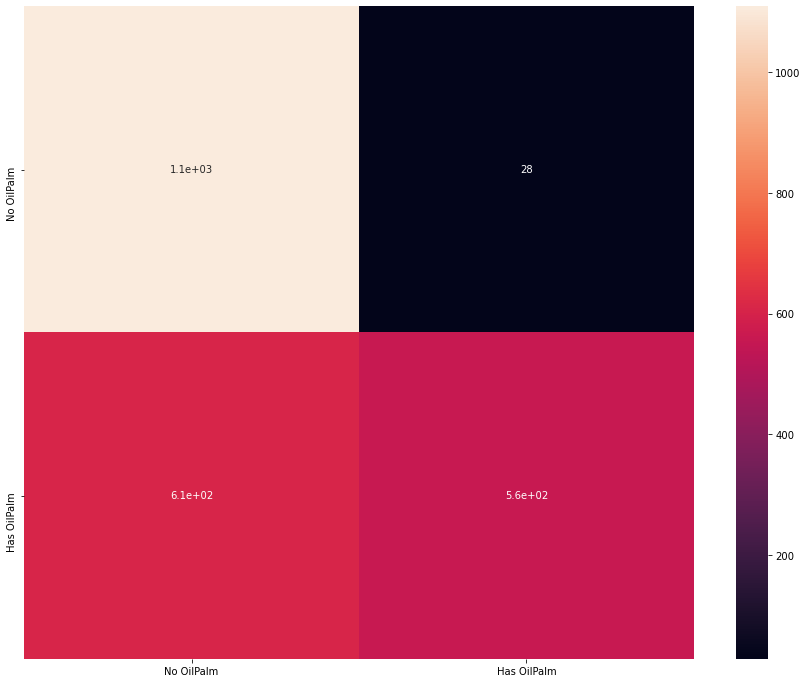

In [239]:
import seaborn as sns
import pandas as pd
labels = ["No OilPalm", "Has OilPalm"]

df_cm = pd.DataFrame(cm, index = labels,
                  columns = labels)
                  
plt.figure(figsize = (15, 12))
sns.heatmap(df_cm, annot=True)

The confusion matrix alludes to the already discussed source of possible issue in out data. We can that the model returned a high number of False Positive in the data. This could possibly have resulted from images with `No Oil Palm` being labelled as `Has OilPalm`. Thereby misleading the model in viewing these data wrongly. This a growing area of research in the deep learning domain and has led to the proposition of techiques such as using robust loss function such as Normalized Focal Loss, Reverse Cross Entropy, Early Learning Regularization and using Contrastive learning to limit the use of the wrongly labelled datasets. 

### What did not work in the modelling process.
In the course of developing this analysis notebook, several model architectures, optimizations methods, regularisations and training loops were tested. While some of these architectures have been shown to work for classification tasks in other application contexts, they failed in this particular use due to:
- the peculiarity of the datasets relating to its inherent noise and data imbalance, 
- the number of trainable parameters in some of these architectures also contributed to influencing if the model would learn or not from the provided data. 

Some of the architectures that were tested include:
- AlexNet, 
- VGG16, 
- <a href="https://paperswithcode.com/lib/timm/resnext">ResNext</a>
- and ResNet50
These architectures were trained both from scratch and using their pretrained weights on image net, but finetuning only the last layer in different approach. 

In the process of searching for the most optimal model, another approach that was tested was cross validation to enable the model robustly capture all the diversity and corresponding complexity in the data. This in turn soon proved to be a very computational approach and did not yield an significantly improvement in the model performance on the validation set.

### References

https://medium.com/analytics-vidhya/handling-imbalanced-dataset-in-image-classification-dc6f1e13aeee

https://medium.com/udacity-pytorch-challengers/ideas-on-how-to-fine-tune-a-pre-trained-model-in-pytorch-184c47185a20

https://www.assemblyai.com/blog/pytorch-lightning-for-dummies/




https://cs231n.github.io/transfer-learning/

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://pytorch.org/docs/stable/index.html


https://pytorch-lightning.readthedocs.io/en/latest/

https://docs.wandb.ai/

https://www.pluralsight.com/guides/introduction-to-resnet

https://www.pluralsight.com/guides/image-classification-with-pytorch


https://www.youtube.com/watch?v=4JFVhJyTZ44


https://wandb.ai/wandb/wandb-lightning/reports/Image-Classification-using-PyTorch-Lightning--VmlldzoyODk1NzY#%F0%9F%93%89-9


https://wandb.ai/wandb/wandb-lightning/reports/Transfer-Learning-Using-PyTorch-Lightning--VmlldzoyODk2MjA

### CODE SNIPPET FOR COMPARING THE PERFORMANCE OF CLASSIFICATION MODELS
Using the Precision and Recall Curve. 
##### Plot precision-recall curve

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(recall_scores, precision_scores, label='Logistic Regression')
ax.plot(l2_recall_scores, l2_precision_scores, label='L2 Logistic Regression')
baseline = len(y_test[y_test==1]) / len(y_test)
ax.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='center left');


https://medium.com/@douglaspsteen/precision-recall-curves-d32e5b290248